In [1]:
import torch
from model import VanillaSeq2Seq, PeakySeq2Seq, AttentionSeq2Seq
from dataset import get_dataset, fra_words, eng_words, seq_len, pad, bos

torch.manual_seed(9527)

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")

In [2]:
from time import perf_counter, ctime
from datetime import timedelta


def train(model, dataloader, backward, epochs=50):
    losses, *_ = [], model.to(device).train()
    label, start_time = model.__class__.__name__, perf_counter()
    print(f"{label} @ {ctime()}\n")
    for epoch in range(epochs):
        total_loss, start = 0, perf_counter()
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            logits = model(source, target, bos=bos, teacher_forcing=True)
            loss = backward(logits.view(-1, logits.size(-1)), target.view(-1))
            loss = loss.cpu().item()
            losses.append(loss)
            total_loss += loss
        print(
            f"Epoch {epoch+1:>2}/{epochs}, Time {timedelta(seconds=int(perf_counter()-start))}, Loss {total_loss / len(dataloader)}"
        )
    print(f"\n{label} # {timedelta(seconds=int(perf_counter() - start_time))}\n\n")
    return losses


@torch.no_grad()
def eval(models, dataloader, print_result):
    for model in models:
        model.to(device).eval()
    for x, Y in dataloader:
        outputs = []
        for model in models:
            logits = model(x.to(device), bos=bos).argmax(dim=-1)
            outputs.append([index for index in logits.view(-1).tolist() if index > 1])
        print_result(
            [index for index in x.view(-1).tolist() if index > 1],
            [index for index in Y.view(-1).tolist() if index > 1],
            outputs,
        )

In [3]:
input_size, output_size = len(fra_words) + 2, len(eng_words) + 2

train_loader, test_loader = get_dataset()

In [4]:
def get_backward(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)

    def backward(logits, target):
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    return backward


models, losses_list = [], []
for Model in [VanillaSeq2Seq, PeakySeq2Seq, AttentionSeq2Seq]:
    torch.manual_seed(9527)
    model = Model(input_size, output_size, max_len=seq_len, padding_idx=pad)
    torch.manual_seed(9527)
    models.append(model)
    backward = get_backward(model)
    losses = train(model, train_loader, backward)
    losses_list.append(losses)

VanillaSeq2Seq @ Mon Sep  8 19:36:34 2025

Epoch  1/50, Time 0:01:20, Loss 2.9713251923561095
Epoch  2/50, Time 0:01:20, Loss 2.0333705849647523
Epoch  3/50, Time 0:01:16, Loss 1.6609089066505431
Epoch  4/50, Time 0:01:16, Loss 1.4188337593555451
Epoch  5/50, Time 0:01:29, Loss 1.2440713223457336
Epoch  6/50, Time 0:01:22, Loss 1.1128119430065155
Epoch  7/50, Time 0:01:19, Loss 1.0114444284439086
Epoch  8/50, Time 0:01:16, Loss 0.9302958839416504
Epoch  9/50, Time 0:01:19, Loss 0.8624504960536957
Epoch 10/50, Time 0:01:21, Loss 0.8101932082653046
Epoch 11/50, Time 0:01:17, Loss 0.7619339126586914
Epoch 12/50, Time 0:01:23, Loss 0.7230575444936752
Epoch 13/50, Time 0:01:21, Loss 0.6863366225719452
Epoch 14/50, Time 0:01:19, Loss 0.6561912850856781
Epoch 15/50, Time 0:01:17, Loss 0.6287569200277329
Epoch 16/50, Time 0:01:18, Loss 0.6044865733146667
Epoch 17/50, Time 0:01:19, Loss 0.581485060453415
Epoch 18/50, Time 0:01:19, Loss 0.5592569828271866
Epoch 19/50, Time 0:01:19, Loss 0.543534

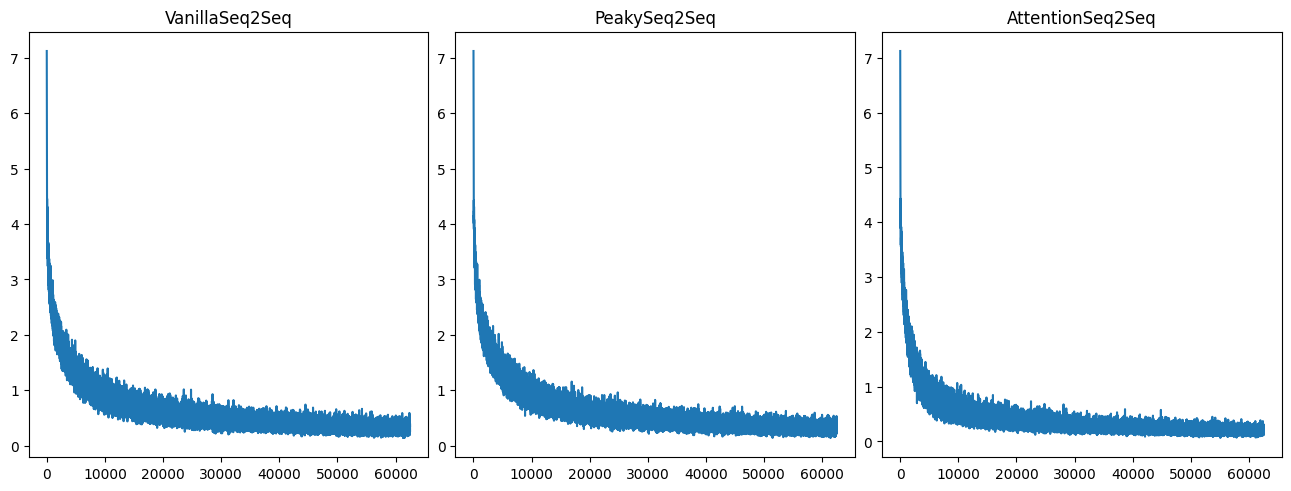

In [5]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 3, figsize=(12.8, 4.8), layout="constrained")
for i, (ax, losses) in enumerate(zip(axs, losses_list)):
    ax.set_title(models[i].__class__.__name__)
    ax.plot(losses)

In [6]:
def print_result(source, target, outputs):
    print("source:", " ".join(fra_words[i - 2] for i in source))
    print("target:", " ".join(eng_words[i - 2] for i in target))
    for output in outputs:
        print("output:", " ".join(eng_words[i - 2] for i in output))
    print()


eval(models, test_loader, print_result)

source: peux-tu aller au bureau en train ?
target: can you go to the office by train ?
output: can you ride a bicycle ?
output: can you go to the station by restaurant ?
output: can you go to the office ?

source: elle a l'air mieux dans des vêtements japonais .
target: she looks better in japanese clothes .
output: she looks japanese in order to wear a paper .
output: she looks better in days .
output: she looks like in some large red living .

source: tom ne la vit pas .
target: tom did n't see it .
output: tom does n't have to live .
output: tom did n't be the two lives .
output: tom has n't seen it .

source: il fait assez froid .
target: it 's pretty cold .
output: it 's kind of cold .
output: it 's cold enough .
output: it is pretty cold .

source: vous pouvez la prendre .
target: you can take it .
output: you can take it .
output: you may take the way .
output: you can take it .

source: il mit du lait dans son café .
target: he put milk in his coffee .
output: he put in milk in